step_size=5000

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler

import argparse
import random
import os
import math

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

In [5]:
seed_torch(42)

## 网络模型

In [6]:
class MLP(nn.Module):
    """Deep Neural Network"""

    def __init__(self, L, M, dim_hidden, hidden_layers, dim_out,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        
        dim_in = M * 2 + 2
        
        model = nn.Sequential()
        
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
            
        self.model = model
        
        self.L = L
        self.M = M
        
        if init_name is not None:
            self.init_weight(init_name)

            
        self.k = nn.Parameter(torch.arange(1, self.M+1), requires_grad=False)
                    
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
#         for layer, param in enumerate(self.parameters()):
#             if layer % 2 == 1:
#                 nn.init.constant_(param, 0.0)
#             else:
#                 nn_init(param)
                
    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        out = torch.cat([t, torch.ones_like(t), 
                            torch.cos(self.k * w * x), torch.sin(self.k * w * x)], dim = 1) 
        
        return out    
            
    def forward(self, H):
        t = H[:, 0:1]
        x = H[:, 1:2]
        
        H = self.input_encoding(t, x)
        H = self.model(H)
        
        return H
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params
    
    def print(self):
        print(self.bias)

In [7]:
model = MLP(L=2.0, M=10, dim_hidden=128, hidden_layers=4, dim_out=1)

## PDE部分

KDV方程：
$$
\left\{\begin{matrix}
&u_{t}+ \lambda_1 u u_{x} + \lambda_2 u_{xxx}=0  ,(t,x)\in (0,1)\times (-1,1),  \\
&u(0,x)= cos(\pi x),  \\
&u(t,-1)=u(t,1),t\in [0,1],  \\
&u_x(t,-1)=u_x(t,1),x\in [0,1].
\end{matrix}\right.
$$
$\lambda_1 = 1.000$, $\lambda_2 = 0.0025$.

In [8]:
def net_r(self, tx):
    tx.requires_grad_(True)

    u = self.model(tx)

    grad_u = grad(u, tx)[0]
    u_t = grad_u[:,[0]]
    u_x = grad_u[:,[1]]
    u_xx = grad(u_x, tx)[0][:, [1]]
    u_xxx = grad(u_xx, tx)[0][:, [1]]

    residual = u_t  + u * u_x + 0.0025 * u_xxx

    return residual

def net_u(self, tx):
    u = self.model(tx)
    return u

## Options

In [9]:
import argparse
class Options_KDV(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=12, help='neurons in hidden layers')     # 10 9
        parser.add_argument('--hidden_layers', type=int, default=9, help='number of hidden layers')    # 4  20
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=0.001, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=300000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=2500, help='epochs for LBFGS optimizer')
        parser.add_argument('--newton_iter', type=int, default=100, help='newton_iter for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=10000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.9, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--tol', type=float, default=100, help='the annealing scheme')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.load_model = False
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        # arg.cuda = False
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(arg.cuda)
        print(arg.device)
        return arg

args = Options_KDV().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

True
cuda
9


In [10]:
model.to(device)
args.model=model

## 数据集生成

In [11]:
class Trainset_KDV():
    def __init__(self, *args):
        self.args = args
        self.shape = (self.args[1], self.args[0])
        
    def __call__(self):
        return self.data()
    
    def data(self):
        n_t = self.args[0]
        n_x = self.args[1]
        n_ics = self.args[2]
        
        t = np.linspace(0, 1, n_t)
        x = np.linspace(-1, 1, n_x)
        t, x = np.meshgrid(t, x)
        tx = np.hstack((t.reshape(-1,1), x.reshape(-1,1)))
        
        t_ics = np.zeros(n_ics)
        x_ics = np.linspace(-1, 1, n_ics)
        tx_ics = np.hstack([t_ics.reshape(-1,1),x_ics.reshape(-1,1)])
        
        u_ics = np.cos(math.pi*x_ics)
        u_ics = u_ics.reshape(-1,1)
        
        
        M = np.triu(np.ones([n_t, n_t]),k=1).T
        
        tx = torch.from_numpy(tx).float().to(device)
        tx_ics = torch.from_numpy(tx_ics).float().to(device)
        u_ics = torch.from_numpy(u_ics).float().to(device)
        M = torch.from_numpy(M).float().cuda()
        
        return tx, tx_ics, u_ics, M

In [12]:
trainset = Trainset_KDV(100, 256, 512)
args.trainset = trainset
tx, tx_ics, u_ics, M = trainset()

## 训练

In [13]:
class Trainer_Wave(object):
    def __init__(self, args):
        self.model = args.model
        self.lr = args.lr
        self.gamma = args.gamma
        self.trainset = args.trainset
        self.step_size = args.step_size
        self.model_name = self.model.__class__.__name__     
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=self.gamma)
        self.epochs_Adam = args.epochs_Adam
        self.tol = args.tol
        
        # data
        self.tx, self.tx_ics, self.u_ics, self.M = self.trainset()
 
        # Logger
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []
        self.epoch_log = []
        

    def net_r(self, tx):
        tx.requires_grad_(True)

        u = self.model(tx)

        grad_u = grad(u, tx)[0]
        u_t = grad_u[:,[0]]
        u_x = grad_u[:,[1]]
        u_xx = grad(u_x, tx)[0][:, [1]]
        u_xxx = grad(u_xx, tx)[0][:, [1]]

        residual = u_t  + u * u_x + 0.0025 * u_xxx

        return residual

    def net_u(self, tx):
        u = self.model(tx)
        
        return u
    
    def residuals_and_weights(self):
        r_pred = self.net_r(self.tx)
        r_pred = r_pred.reshape(self.trainset.shape) # :shape(256,100)
        L_t = torch.mean(r_pred**2, axis=0) # :shape(100)
        with torch.no_grad():
            W = torch.exp(-self.tol * (self.M @ L_t))
        return L_t, W
    
    def loss_ics(self):
        u_pred = self.net_u(self.tx_ics)
        loss_ics = torch.mean((u_pred - self.u_ics)**2)
        return loss_ics
    
    def loss_res(self):
        r_pred = self.net_r(self.tx)
        loss_r = torch.mean(r_pred**2)
        return loss_r
    
    def loss(self):
        L0 = 100 * self.loss_ics()
        L_t, W = self.residuals_and_weights()
        loss = torch.mean(W * L_t) + L0
        
        return loss
    
    def train(self):
        start = time.time()
        
        for epoch in range(self.epochs_Adam):
            self.optimizer_Adam.zero_grad()
            loss_value = self.loss()
            loss_value.backward()
            self.optimizer_Adam.step()
            
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()            
            
            if epoch % 1000 == 0:
                loss_value = self.loss()
                loss_ics_value = self.loss_ics()
                loss_res_value = self.loss_res()
                
                L_t_value, W_value = self.residuals_and_weights()
                
                self.loss_log.append(loss_value.detach().cpu())
                self.loss_ics_log.append(loss_ics_value.detach().cpu())
                self.loss_res_log.append(loss_res_value.detach().cpu())
                self.W_log.append(W_value.detach().cpu())
                self.L_t_log.append(L_t_value.detach().cpu())
                self.epoch_log.append(epoch)
                
                end = time.time()
                running_time = end - start
                start = time.time()
                
                print(f'Epoch #  {epoch}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_ics:{loss_ics_value:.2e}, loss_res:{loss_res_value:.2e},')

In [14]:
trainer = Trainer_Wave(args)
trainer.train()

RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 10.76 GiB total capacity; 437.14 MiB already allocated; 28.56 MiB free; 480.00 MiB reserved in total by PyTorch)
Exception raised from malloc at /pytorch/c10/cuda/CUDACachingAllocator.cpp:272 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x42 (0x7f328252d1e2 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1e64b (0x7f328278364b in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1f464 (0x7f3282784464 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libc10_cuda.so)
frame #3: <unknown function> + 0x1faa1 (0x7f3282784aa1 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libc10_cuda.so)
frame #4: <unknown function> + 0x22f8b17 (0x7f3284c8eb17 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cuda.so)
frame #5: <unknown function> + 0x22e1e34 (0x7f3284c77e34 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cuda.so)
frame #6: at::native::sum_out(at::Tensor&, at::Tensor const&, c10::ArrayRef<long>, bool, c10::optional<c10::ScalarType>) + 0x108 (0x7f32be378788 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #7: at::native::sum(at::Tensor const&, c10::ArrayRef<long>, bool, c10::optional<c10::ScalarType>) + 0x4b (0x7f32be378d9b in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x129a2b4 (0x7f32be8302b4 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #9: <unknown function> + 0xa564fe (0x7f32bdfec4fe in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #10: at::sum(at::Tensor const&, c10::ArrayRef<long>, bool, c10::optional<c10::ScalarType>) + 0x123 (0x7f32be787a53 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x2e5888b (0x7f32c03ee88b in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #12: <unknown function> + 0xa564fe (0x7f32bdfec4fe in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::Tensor::sum(c10::ArrayRef<long>, bool, c10::optional<c10::ScalarType>) const + 0x123 (0x7f32be8e0af3 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x336aaaa (0x7f32c0900aaa in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #15: torch::autograd::Engine::evaluate_function(std::shared_ptr<torch::autograd::GraphTask>&, torch::autograd::Node*, torch::autograd::InputBuffer&, std::shared_ptr<torch::autograd::ReadyQueue> const&) + 0x3fd (0x7f32c09063fd in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #16: torch::autograd::Engine::thread_main(std::shared_ptr<torch::autograd::GraphTask> const&) + 0x451 (0x7f32c0907fa1 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #17: torch::autograd::Engine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x89 (0x7f32c0900119 in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_cpu.so)
frame #18: torch::autograd::python::PythonEngine::thread_init(int, std::shared_ptr<torch::autograd::ReadyQueue> const&, bool) + 0x4a (0x7f32ce0a04ba in /home/stu1/.conda/envs/pde/lib/python3.6/site-packages/torch/lib/libtorch_python.so)
frame #19: <unknown function> + 0xc819d (0x7f3483fbe19d in /home/stu1/.conda/envs/pde/bin/../lib/libstdc++.so.6)
frame #20: <unknown function> + 0x8609 (0x7f3486cbb609 in /lib/x86_64-linux-gnu/libpthread.so.0)
frame #21: clone + 0x43 (0x7f3486be0163 in /lib/x86_64-linux-gnu/libc.so.6)


In [34]:
file = f'{args.epochs_Adam}epoch,{args.step_size}step_size,{args.tol}tol'
if os.path.exists(file)==False:
    os.mkdir(file)

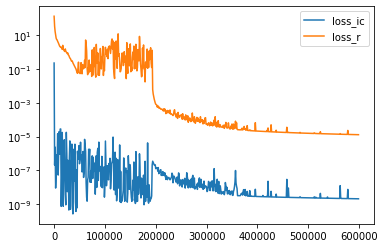

In [35]:
plt.plot(trainer.epoch_log, trainer.loss_ics_log, label='loss_ic')
plt.plot(trainer.epoch_log, trainer.loss_res_log, label='loss_r')
plt.yscale('log')
plt.legend()
plt.savefig(f'{file}/loss.jpg')

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$x$')

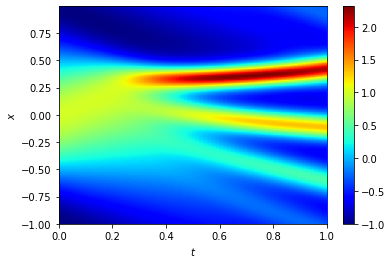

In [36]:
# load the data
data = scipy.io.loadmat('data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

In [38]:
# Get trained network parameters
TX = np.hstack((TT.reshape(-1,1), XX.reshape(-1,1)))
TX = torch.from_numpy(TX).double()

model = trainer.model.cpu().double()
u_pred = model(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 2.643e-03


/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher

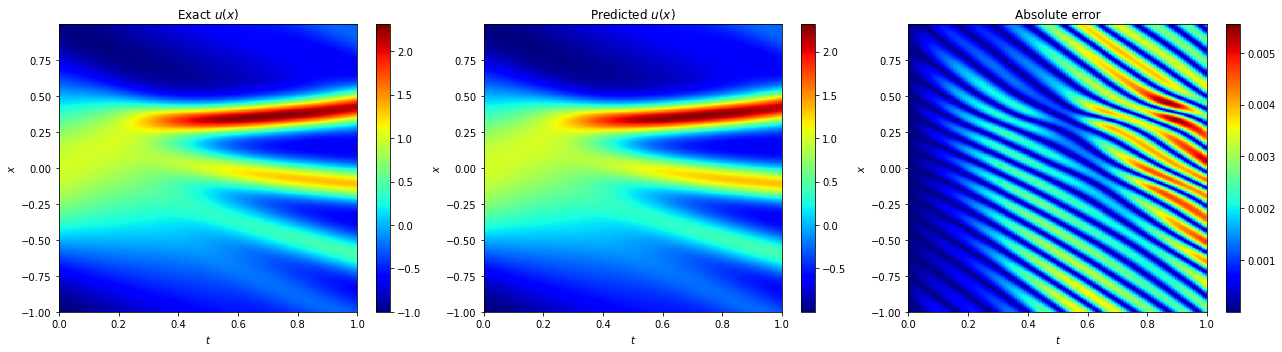

In [39]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.savefig(f'{file}/predict.jpg')
plt.show()

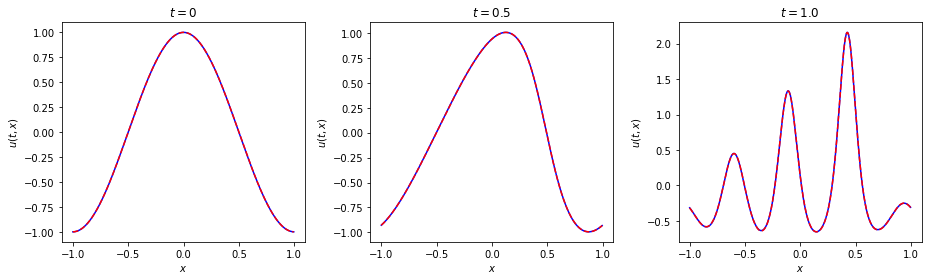

In [40]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue')
plt.plot(x_star, u_pred[:,0], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,25], color='blue')
plt.plot(x_star, u_pred[:,25], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,-1], color='blue')
plt.plot(x_star, u_pred[:,-1], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.savefig(f'{file}/check_t.jpg')
plt.show()

In [41]:
L_t = trainer.L_t_log[-1].numpy()
W = trainer.W_log[-1].numpy()
t_r = np.linspace(0, 1, 100)

Text(0, 0.5, '$w(t)$')

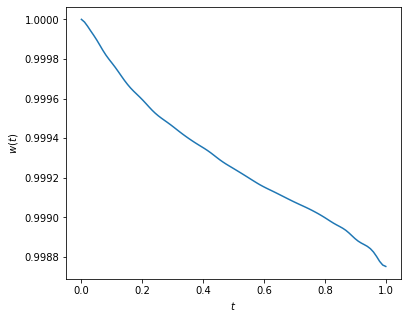

In [42]:
fig = plt.figure(figsize=(6, 5))
plt.plot(t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')

Text(0, 0.5, '$\\mathcal{L}(t, \\theta)$')

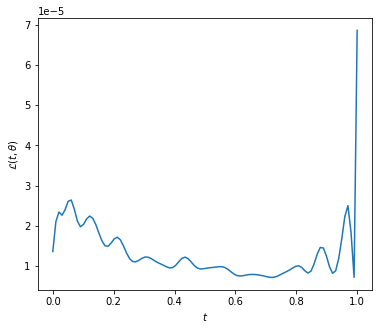

In [43]:
fig = plt.figure(figsize=(6, 5))
plt.plot(t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')

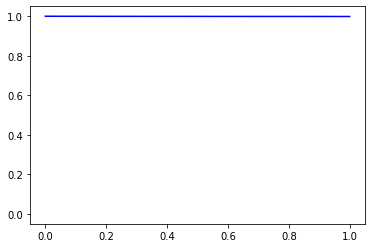

In [44]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig = plt.figure()
ims = []
for i in range(len(trainer.W_log)):
    im = plt.plot(t_r, trainer.W_log[i],'b')
    ims.append(im)
ani = animation.ArtistAnimation(fig, ims, interval=20, repeat_delay=50)
ani.save(f"{file}/weight.gif",writer='pillow')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig = plt.figure()
ims = []
for i in range(len(trainer.L_t_log)):
    im = plt.plot(t_r, trainer.L_t_log[i],'b')
    plt.yscale('log')
    ims.append(im)
ani = animation.ArtistAnimation(fig, ims, interval=20, repeat_delay=50)
ani.save(f"{file}/loss_t.gif",writer='pillow')